# Comparison of MLP and Bayes NN on MNIST dataset

### Importing libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from abc import ABC, abstractmethod


import zhusuan as zs

import numpy as np
import matplotlib.pyplot as plt
import mnist

tf.set_random_seed(123)
np.random.seed(321)

/home/glegeza/Programming/semestr2/bayessian_deep_learning/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/glegeza/Programming/semestr2/bayessian_deep_learning/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/glegeza/Programming/semestr2/bayessian_deep_learning/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint

### Load data

In [2]:

train_X = mnist.train_images()[:5000]
train_X = train_X.reshape(train_X.shape[0], -1) / 255.
train_y = mnist.train_labels()[:5000]

test_X = mnist.test_images()[:1000]
test_X = test_X.reshape(test_X.shape[0], -1) / 255.
test_y = mnist.test_labels()[:1000]

train_X, val_X = train_X[:-1000], train_X[-1000:]
train_y, val_y = train_y[:-1000], train_y[-1000:]

n_train, x_dim = train_X.shape
y_dim = 10

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape

((4000, 784), (4000,), (1000, 784), (1000,), (1000, 784), (1000,))

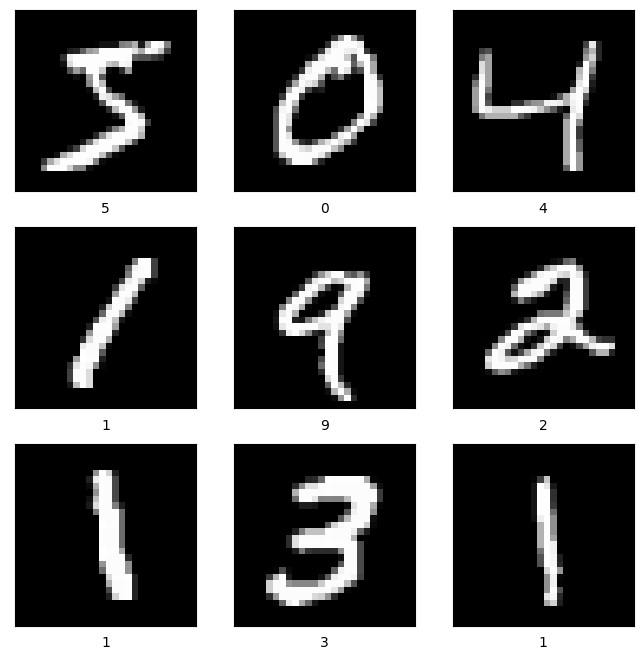

In [3]:
fig, ax = plt.subplots(3, 3, figsize=(8, 8))
for i, axi in enumerate(ax.flat):
    axi.imshow(train_X[i].reshape(28, 28), cmap='gray')
    axi.set(xticks=[], yticks=[], xlabel=train_y[i])
plt.show()

### Standarize data

In [4]:
def standardize(data_train, data_test):
    """
    Standardize a dataset to have zero mean and unit standard deviation.

    :param data_train: 2-D Numpy array. Training data.
    :param data_test: 2-D Numpy array. Test data.

    :return: (train_set, test_set, mean, std), The standardized dataset and
        their mean and standard deviation before processing.
    """
    std = np.std(data_train, 0, keepdims=True)
    std[std == 0] = 1
    mean = np.mean(data_train, 0, keepdims=True)
    data_train_standardized = (data_train - mean) / std
    data_test_standardized = (data_test - mean) / std
    mean, std = np.squeeze(mean, 0), np.squeeze(std, 0)
    return data_train_standardized, data_test_standardized, mean, std

In [5]:
train_X_standard, test_X_standard, _, _ = standardize(train_X, test_X)
train_y_one_hot = np.eye(y_dim)[train_y]
test_y_one_hot = np.eye(y_dim)[test_y]

### Defintion of parameters

In [ ]:
n_hiddens = [50]
layer_sizes = [x_dim] + n_hiddens + [y_dim]

epochs = 20
lr = 0.01
batch_size = 100 

### MLP model

In [ ]:
mlp = Sequential()
mlp.add(Dense(layer_sizes[1], activation="relu", input_shape=(x_dim,)))
for out_dim in layer_sizes[2:-1]:
    mlp.add(Dense(out_dim, activation="relu"))
mlp.add(Dense(y_dim, activation="softmax"))

optimizer = Adam(learning_rate=lr)
mlp.compile(
    loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)
mlp.build()
mlp.summary()

In [ ]:
training_results = mlp.fit(
                            x=train_X,
                            y=train_y,
                            epochs=epochs,
                            batch_size=batch_size,
                            shuffle=True,
                            validation_data=(test_X, test_y),
                        )

In [ ]:
def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):
    fig, ax = plt.subplots(figsize=(15, 4))
    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0, 20])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    # ax.xaxis.set_major_locator(MultipleLocator(5))
    # ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    # ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show()
    plt.close()

In [ ]:
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]

plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, 0.5],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.9, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

### Bayes NN model

In [6]:
@zs.meta_bayesian_net(scope="bnn", reuse_variables=True)
def build_bnn(x, layer_sizes, n_particles):
    bn = zs.BayesianNet()
    h = tf.tile(x[None, ...], [n_particles, 1, 1])
    for i, (n_in, n_out) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        w = bn.normal("w" + str(i), tf.zeros([n_out, n_in + 1]), std=1.,
                      group_ndims=2, n_samples=n_particles)
        h = tf.concat([h, tf.ones(tf.shape(h)[:-1])[..., None]], -1)
        h = tf.einsum("imk,ijk->ijm", w, h) / tf.sqrt(
            tf.cast(tf.shape(h)[2], tf.float32))
        if i < len(layer_sizes) - 2:
            h = tf.nn.relu(h)

    y_mean = bn.deterministic("y_mean", h)
    y_logstd = tf.get_variable("y_logstd", shape=[],
                               initializer=tf.constant_initializer(0.))
    bn.normal("y", y_mean, logstd=y_logstd)
    return bn

In [7]:
@zs.reuse_variables(scope="variational")
def build_mean_field_variational(layer_sizes, n_particles):
    bn = zs.BayesianNet()
    for i, (n_in, n_out) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        w_mean = tf.get_variable(
            "w_mean_" + str(i), shape=[n_out, n_in + 1],
            initializer=tf.constant_initializer(0.))
        w_logstd = tf.get_variable(
            "w_logstd_" + str(i), shape=[n_out, n_in + 1],
            initializer=tf.constant_initializer(0.))
        bn.normal("w" + str(i), w_mean, logstd=w_logstd,
                  n_samples=n_particles, group_ndims=2)
    return bn

In [8]:
n_particles = tf.placeholder(tf.int32, shape=[], name="n_particles")
x = tf.placeholder(tf.float32, shape=[None, x_dim])
y = tf.placeholder(tf.float32, shape=[None, y_dim])
w_names = ["w" + str(i) for i in range(len(layer_sizes) - 1)]

In [9]:
model = build_bnn(x, layer_sizes, n_particles)
variational = build_mean_field_variational(layer_sizes, n_particles)

def log_joint(bn):
    log_pws = bn.cond_log_prob(w_names)
    log_py_xw = bn.cond_log_prob('y')
    return tf.add_n(log_pws) + tf.reduce_mean(log_py_xw, 1) * n_train

model.log_joint = log_joint

lower_bound = zs.variational.elbo(
    model, {'y': y}, variational=variational, axis=0)
cost = lower_bound.sgvb()

optimizer = tf.train.AdamOptimizer(learning_rate=lr)
infer_op = optimizer.minimize(cost)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [10]:
y_mean = lower_bound.bn["y_mean"]
y_pred = tf.arg_max(tf.reduce_mean(y_mean, 0), 1, output_type=tf.int32)
y_true = tf.argmax(y, 1, output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(y_pred, y_true), tf.float32))

Instructions for updating:
Use `tf.math.argmax` instead


In [11]:
lb_samples = 10
ll_samples = 1000
iters = (n_train-1) // batch_size + 1
test_freq = 1

In [12]:
# Run the inference
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(1, epochs + 1):
        perm = np.random.permutation(train_X_standard.shape[0])
        train_X_standard = train_X_standard[perm, :]
        train_y_one_hot = train_y_one_hot[perm]
        lbs = []
        tc = []
        for t in range(iters):
            x_batch = train_X_standard[t * batch_size:(t + 1) * batch_size]
            y_batch = train_y_one_hot[t * batch_size:(t + 1) * batch_size]
            _, lb, train_cost = sess.run(
                [infer_op, lower_bound, cost],
                feed_dict={n_particles: lb_samples,
                           x: x_batch, y: y_batch})
            lbs.append(lb)
            tc.append(np.mean(train_cost))
        print('Epoch {}: Lower bound = {}; Cost = {}'.format(epoch, np.mean(lbs), np.mean(tc)))

        if epoch % test_freq == 0:
            test_acc, test_cost = sess.run(
                [acc, cost],
                feed_dict={n_particles: ll_samples,
                           x: test_X_standard, y: test_y_one_hot})
            print('>> TEST')
            print('>> Test accuracy = {}; Test cost = {}'.format(test_acc, np.mean(test_cost)))

2023-11-12 19:48:37.475410: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-11-12 19:48:37.498611: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1800000000 Hz
2023-11-12 19:48:37.499760: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x561f25bbb780 executing computations on platform Host. Devices:
2023-11-12 19:48:37.499836: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>


Epoch 1: Lower bound = -4227.78759765625
Epoch 2: Lower bound = -3286.369384765625
Epoch 3: Lower bound = -2699.514404296875
Epoch 4: Lower bound = -2337.473388671875
Epoch 5: Lower bound = -2119.9169921875


2023-11-12 19:48:43.990461: W tensorflow/core/framework/allocator.cc:124] Allocation of 3136000000 exceeds 10% of system memory.
2023-11-12 19:48:44.984647: W tensorflow/core/framework/allocator.cc:124] Allocation of 3140000000 exceeds 10% of system memory.
2023-11-12 19:48:46.068609: W tensorflow/core/framework/allocator.cc:124] Allocation of 3140000000 exceeds 10% of system memory.


>> TEST
>> Test accuracy = [0.424]
Epoch 6: Lower bound = -1934.6600341796875
Epoch 7: Lower bound = -1766.67919921875
Epoch 8: Lower bound = -1624.6912841796875
Epoch 9: Lower bound = -1517.6572265625
Epoch 10: Lower bound = -1424.156982421875


2023-11-12 19:48:59.505063: W tensorflow/core/framework/allocator.cc:124] Allocation of 3136000000 exceeds 10% of system memory.
2023-11-12 19:49:00.507553: W tensorflow/core/framework/allocator.cc:124] Allocation of 3140000000 exceeds 10% of system memory.


>> TEST
>> Test accuracy = [0.72]
Epoch 11: Lower bound = -1342.939697265625
Epoch 12: Lower bound = -1278.1011962890625
Epoch 13: Lower bound = -1226.1505126953125
Epoch 14: Lower bound = -1192.05615234375
Epoch 15: Lower bound = -1171.378173828125
>> TEST
>> Test accuracy = [0.805]
Epoch 16: Lower bound = -1134.120849609375
Epoch 17: Lower bound = -1121.31787109375
Epoch 18: Lower bound = -1088.319091796875
Epoch 19: Lower bound = -1076.2244873046875
Epoch 20: Lower bound = -1073.4476318359375
>> TEST
>> Test accuracy = [0.84]
